# Mental Wellness Companion Using LangGraph and Gemini API
## Overview 
This AI Agent aims to create a virtual companion focused on mental wellness. The agent will interact with users through natural language, understand their emotions, and provide personalized responses or exercises.

## Motivation
In this modern era, many people are facing mental health challenges, and most feel uncomfortable sharing their struggles or seeking guidance to address their issues. In fact, some people are unaware of their mental health condition; they believe they are fine but might actually be experiencing mental illness. This AI Agent aims to assess their mental condition and, based on the evaluation, provide motivational content or stress-relief exercises to help improve their well-being—all without the need to disclose their situation to anyone.

## Key Components
1. **Mood Analysis Module**: Leverages Google Generative AI to categorize user input into emotional states (Positive/Negative), enabling targeted support strategies.

2. **Dynamic Response Routing**: Implements an intelligent routing mechanism that dynamically selects intervention paths based on detected mood, ensuring personalized emotional support.

3. **Motivational Quote Generation**: Dynamically generates contextually relevant motivational quotes tailored to the user's specific emotional condition using generative AI.

4. **Stress Relief Intervention**: Provides personalized, condition-specific stress relief exercises when negative emotional states are detected, offering immediate supportive guidance.

5. **Success Story Contextualization**: Generates relatable success stories that align with the user's emotional experience, promoting hope and resilience through narrative inspiration.

6. **Modular State-Based Workflow**: Utilizes LangGraph's StateGraph to create a flexible, extensible workflow with clear state transitions and conditional logic for emotional support.

### Installing Required Libraries

In [37]:
! pip install langgraph langchain_core langchain-google-genai

### Importing Necessary Libraries

In [38]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import START,StateGraph,END
from langgraph.graph.state import CompiledStateGraph
from langchain_core.prompts import PromptTemplate
from IPython.display import Image,display
from typing_extensions import TypedDict
import os
from dotenv import load_dotenv

### Main Code Logic

In [39]:
# Loading All Environment Variables
load_dotenv()

gemini_key = os.getenv('GEMINI_API_KEY')

llm : ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key=gemini_key)

class State(TypedDict):
    text:str
    mood:str
    motivational_quote:str
    exercises:str
    success_story:str
    
# Function for Analyzing Mood
def analyze_mood(state:State):
    prompt = PromptTemplate(input_variables='text',template='Chat if this is the persons condition: {text}. Chat categorize this in the following categorizes: Positive and Negative. Donot give description of it just categorize it into categories defined before. And If its Neutral between Positive and Negative then consider it to positive.')
    message = prompt.format(text=state['text'])
    mood = llm.invoke(message).content
    return {"mood":mood}

# Function for generating motivational_quotye
def motivational_quote_generator(state:State):
    prompt = PromptTemplate(input_variables='text',template='Generate a motivational quote according to the persons condition . If its condition is this :{text}')
    message = prompt.format(text=state['text'])
    motivational_quote = llm.invoke(message).content
    return {"motivational_quote":motivational_quote}

# Function for generating stress relief exercises
def stress_relief_exercises_generator(state:State):
    prompt = PromptTemplate(input_variables='text',template='If this is the persons condition:{text} . Give him atleast 3 exercises that will help the person to heal from this condition and become normal. And note give the response in format')
    message = prompt.format(text=state['text'])
    exercises = llm.invoke(message).content 
    return {"exercises" : exercises}

# Function for generating success stories
def success_story_generator(state:State):
    prompt =PromptTemplate(input_variables='text',template='If this is the condition of a person:{text}. Generate a short success story of a person which is relatatable to this persons condition') 
    message = prompt.format(text=state['text'])
    success_story=llm.invoke(message).content
    return {"success_story":success_story}

# Function for route handling in the graph
def route_handler(state:State):
    if state['mood'].lower().strip() == 'negative':
        return 'stress_relief_exercises'
    return 'motivational_quotes'  

### Initializing and Defining the Workflow Graph

In [40]:
# Initializing the StateGraph
workflow :StateGraph = StateGraph(State)

# Defining Nodes
workflow.add_node('mood_detector',analyze_mood)
workflow.add_node('motivational_quotes',motivational_quote_generator)
workflow.add_node('stress_relief_exercises',stress_relief_exercises_generator)
workflow.add_node('success_stories',success_story_generator)

# Connecting Nodes through Edges

workflow.set_entry_point('mood_detector')
workflow.add_conditional_edges('mood_detector',route_handler,{
    "stress_relief_exercises":'stress_relief_exercises',
    "motivational_quotes":"motivational_quotes"
})
workflow.add_edge("motivational_quotes",END)
workflow.add_edge('stress_relief_exercises','success_stories')
workflow.add_edge('success_stories',END)

graph:CompiledStateGraph = workflow.compile()


### Visualizing the Workflow Graph

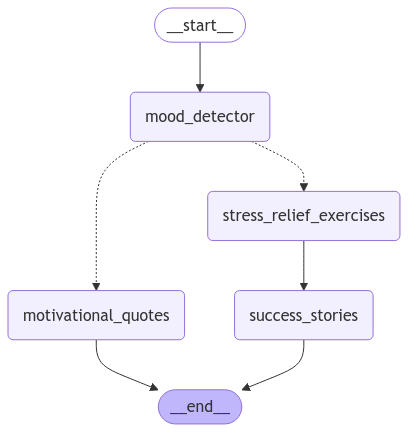

In [41]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Invoking Graph

In [42]:
content = "Hi! I am feeling very good and happy because I won the first prize in a hackathon"
result = graph.invoke({"text": content})

for key, value in result.items():
    print(f"{key} : {value}")

text : Hi! I am feeling very good and happy because I won the first prize in a hackathon
mood : Positive

motivational_quote : "This win isn't just a prize; it's a testament to your talent and dedication.  Keep that fire burning, and the world will see what amazing things you can create!"



In [43]:
content = "Hi! I am not feeling good because I was unable to get any position in the hackathon"
result = graph.invoke({"text": content})

for key, value in result.items():
    print(f"{key} : {value}")

text : Hi! I am not feeling good because I was unable to get any position in the hackathon
mood : Negative

exercises : **Exercise 1: Perspective Shift - Identifying Limiting Beliefs**

* **Action:** Write down all the negative thoughts and beliefs that arose from not winning the hackathon.  Examples: "I'm not good enough," "I'll never succeed," "I wasted my time."  Then, challenge each thought.  Is it truly accurate? What evidence supports it? What evidence contradicts it?  Rewrite each negative thought into a more balanced and realistic statement. For example, change "I'm not good enough" to "I didn't win this time, but I learned valuable skills and can improve for next time."

* **Goal:** To identify and reframe negative self-talk, replacing it with more constructive and rational thinking. This helps reduce feelings of inadequacy and disappointment.

* **Frequency:** Do this exercise once daily for at least three days.


**Exercise 2:  Focusing on the Positive & Growth Mindset**

* 